
# BANKING CUSTOMER CHURN ANALYSIS

In [102]:
from google.colab import drive

In [103]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(color_codes=True)
%matplotlib inline

In [105]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle_1/Bank Customer Churn Prediction.csv')

In [106]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## __Problem statement__

### A customer is most likely to be churned when the customer do not use any of the banking products for more than 3 months. There are several reasons why the customer will churn. Our objective in this project is to predict whether the customer will churn or not based on the dependent variables given

### Data Description

In [107]:
print('The number of rows (observations) is',df.shape[0],'\n''The number of columns (variables) is',df.shape[1])

The number of rows (observations) is 10000 
The number of columns (variables) is 12


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [ ]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


There are no missing values. 2 variables are categorical and remaining numeric.

## Data Dictionary

1. __customer_id:__ Unique customer id
2. __credit_score:__ Given by bank to customer depending on customer behaviour to make business decisions
3. __country:__ Country
4. __gender:__ Gender
5. __age:__ Age
6. __tenture:__ How long is the customer has been with the bank
7. __balance:__ Monthly balance maintained by customer
8. __products_number:__ No. of products owned by the customer
9. __credit_card:__ Customer having credit card or not (0 means not having credit card, 1 means having credit card)
10. __active_member:__ Active user of the Bank
11. __estimated_salary:__ salary of the customer
12. __churn:__ 0 means not churned, 1 means churned

### Check for duplicate data

In [108]:
dups=df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [109]:
df.churn.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: churn, dtype: float64

In this dataset, 20% of data are churned customers and remaining 80% data not churned

In [110]:
for i in df.columns:
    if df[i].dtype == 'object':
        print (i)
        print(df[i].value_counts())
        print('\n')

country
France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64


gender
Male      5457
Female    4543
Name: gender, dtype: int64




We have two variables with object dtype which needs to be converted before model building

### Checking for outliers using boxplot

customer_id


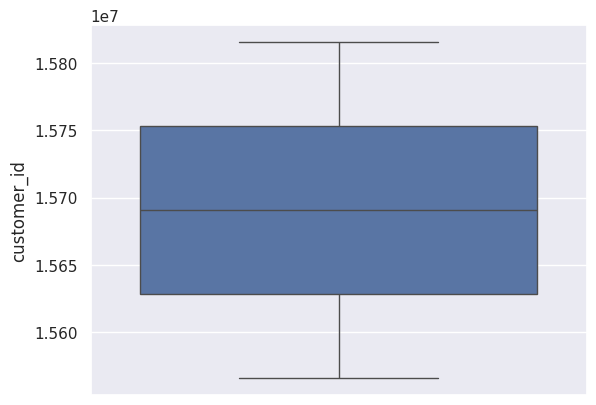

credit_score


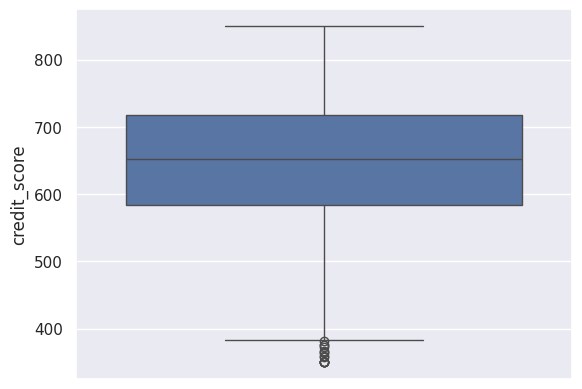

age


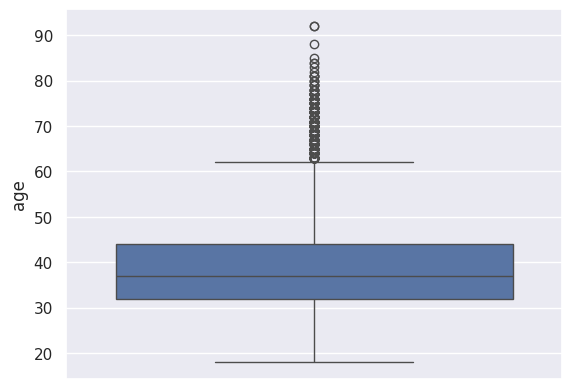

tenure


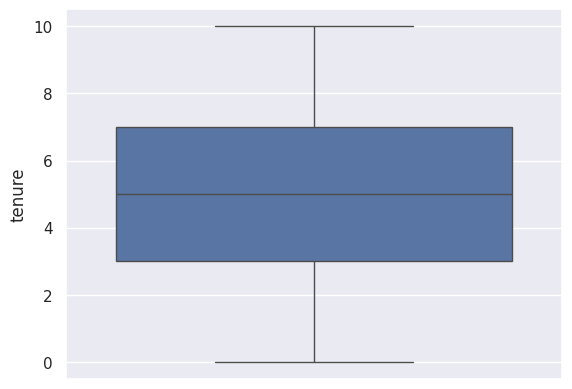

balance


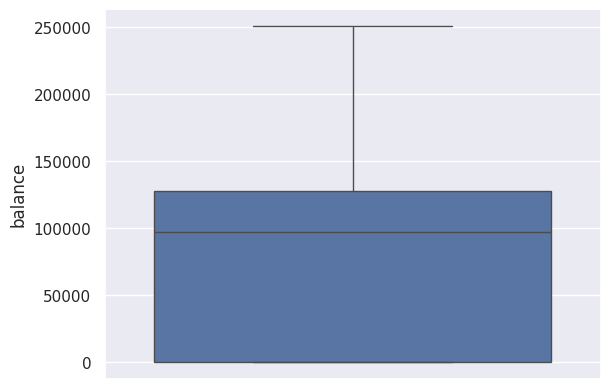

products_number


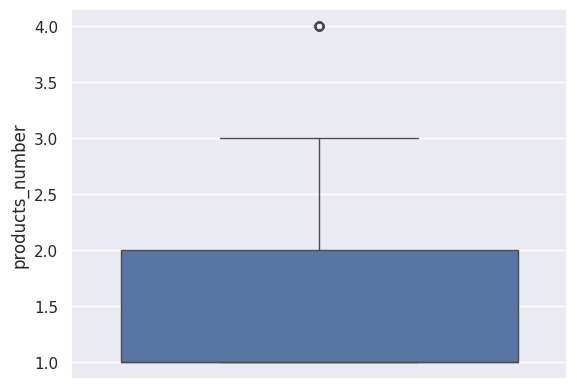

credit_card


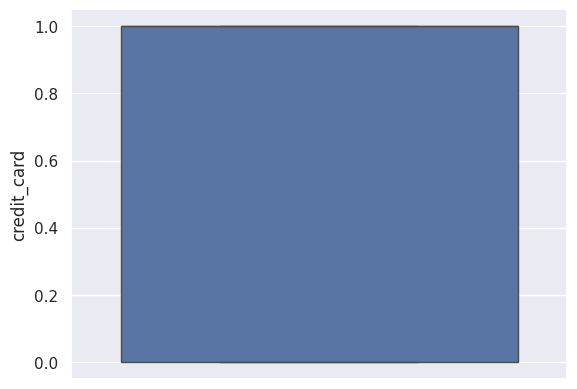

active_member


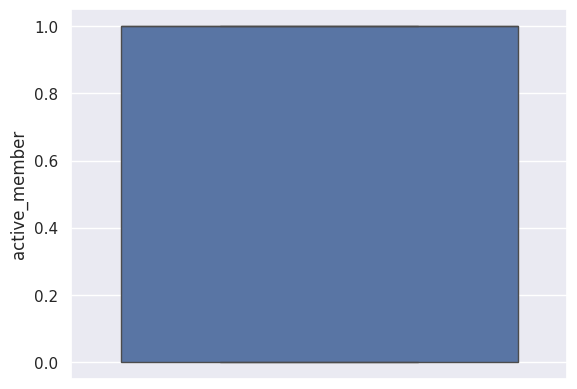

estimated_salary


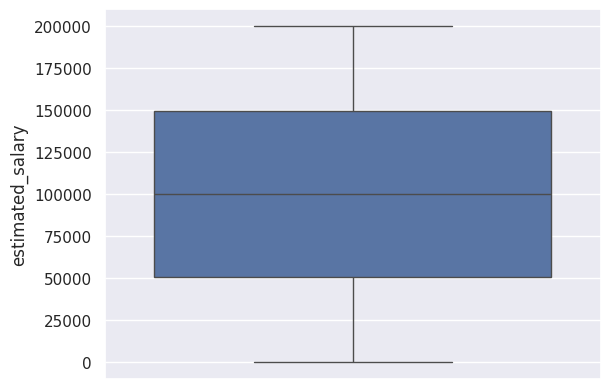

churn


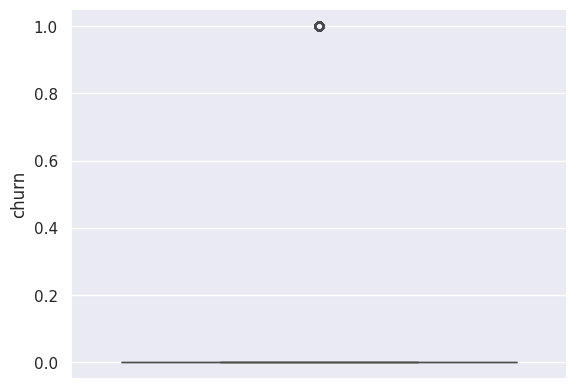

In [111]:
for i in df.columns:
    if df[i].dtype != 'object':
        print(i)
        sns.boxplot(df[i],whis=1.5)
        plt.show();

#### Treating outliers only for age

In [112]:
def remove_outlier(df_columns):
    Q1,Q3=np.percentile(df_columns,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [113]:
lr,ur=remove_outlier(df['age'])
print('Lower Range :',lr,'\nUpper Range :',ur)
df['age']=np.where(df['age']>ur,ur,df['age'])
df['age']=np.where(df['age']<lr,lr,df['age'])

Lower Range : 14.0 
Upper Range : 62.0


#### Plotting age for outliers check after treating the outliers

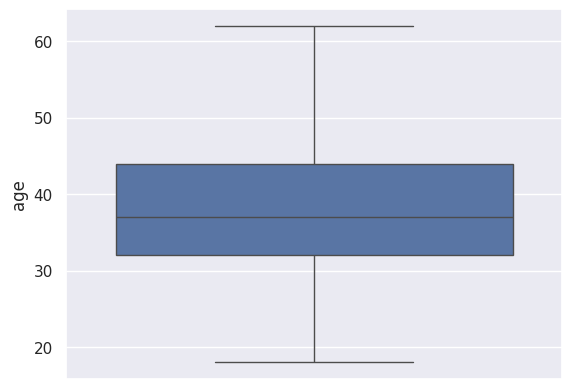

In [115]:
val=['age']
for i in val:
    sns.boxplot(df[i],whis=1.5)
    plt.show();

In [ ]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.660800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,9.746704,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,62.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## EDA

<ipython-input-18-9c72102bc5e9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True);


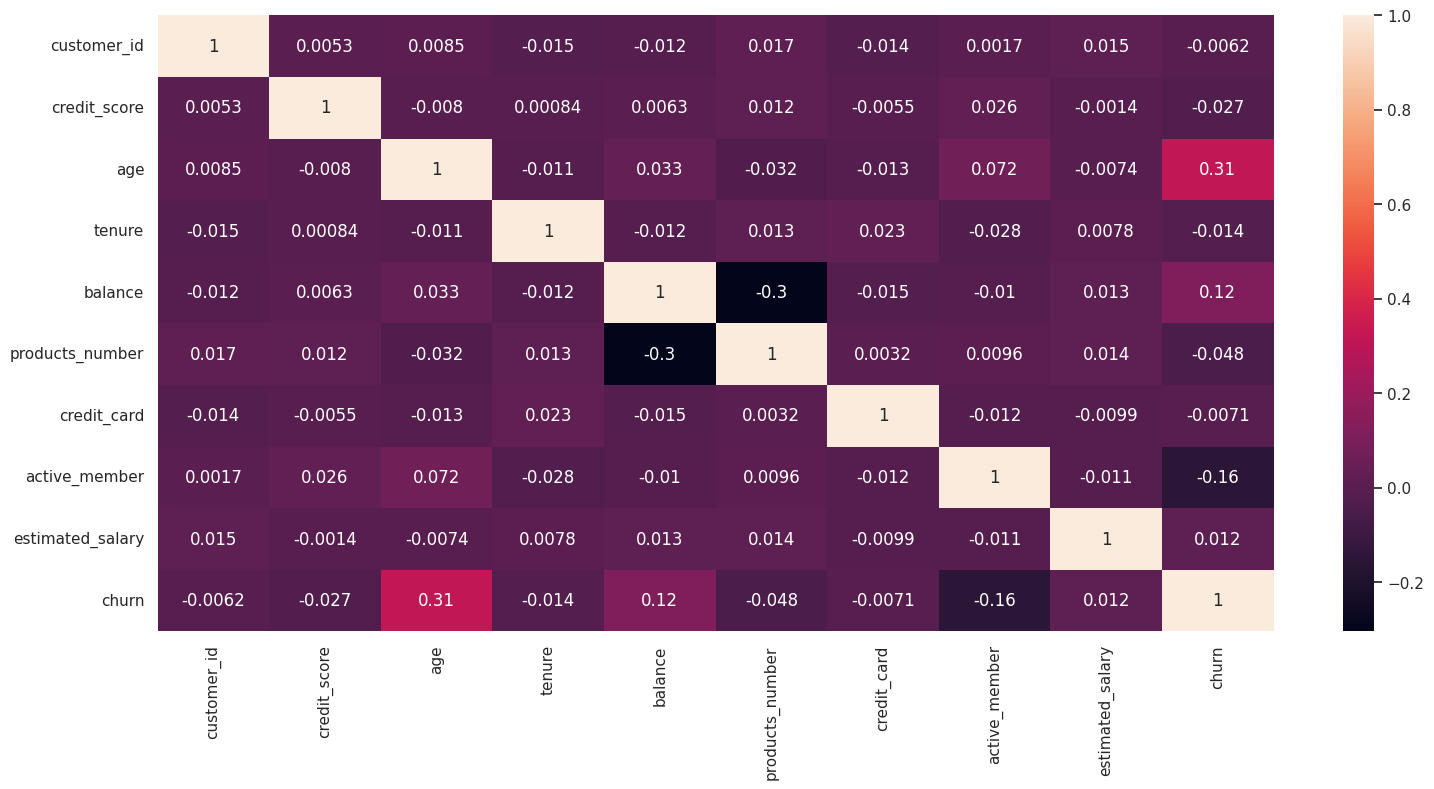

In [18]:
plt.figure(figsize=(18,8))
sns.heatmap(df.corr(), annot=True);

To determine the strength of the relationship between two variables we check for correlation.

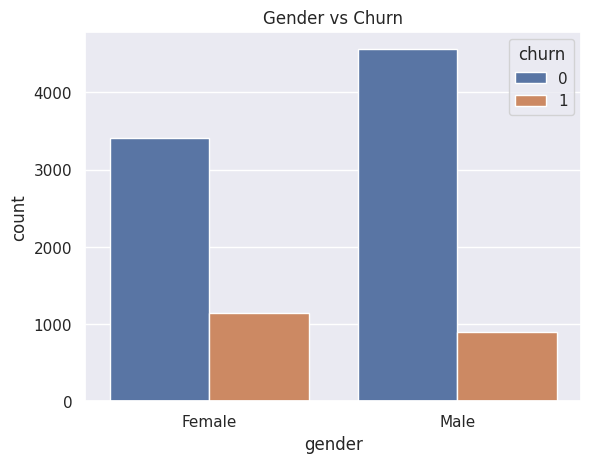

In [128]:
counts = df.groupby(['gender'])['churn'].value_counts().rename('count').reset_index()
sns.barplot(x='gender',y='count',hue='churn', data=counts).set_title('Gender vs Churn');

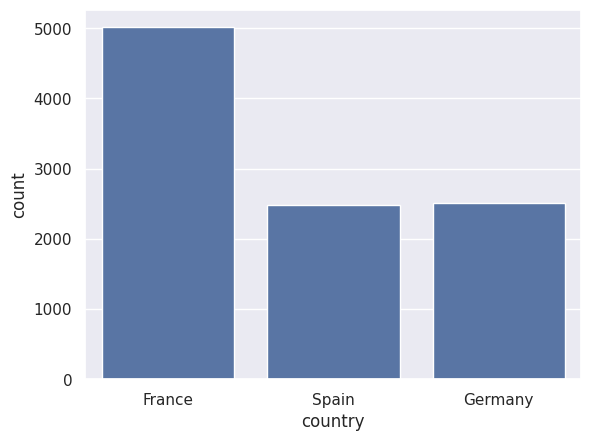

In [138]:
sns.countplot(data=df, x='country');

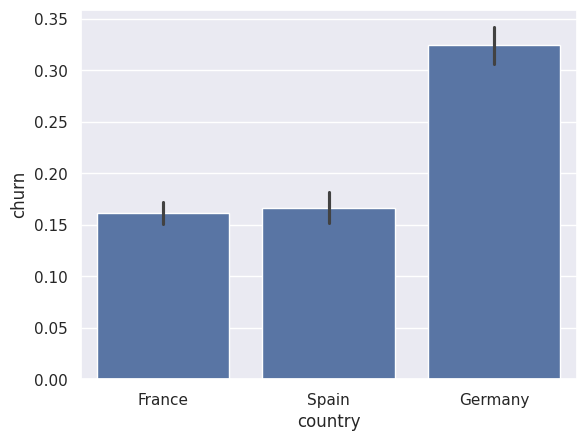

In [136]:
sns.barplot(x='country',y='churn',data=df);

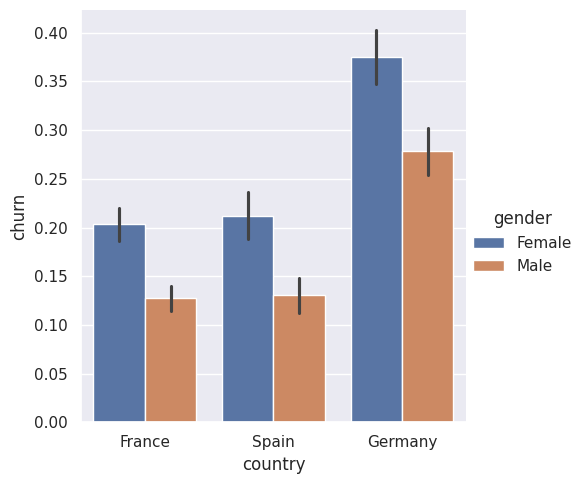

In [16]:
sns.catplot(data=df, kind='bar',x='country',y='churn',hue='gender');

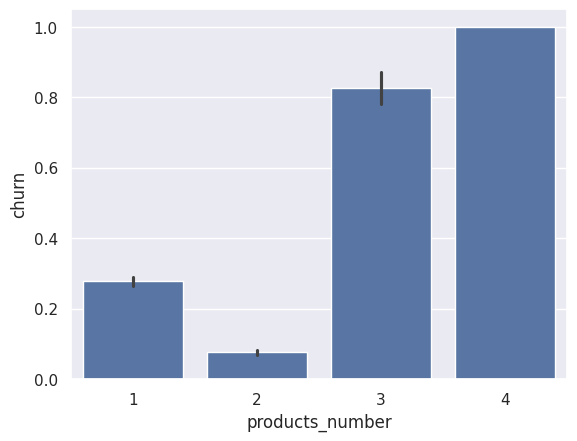

In [17]:
sns.barplot(data=df, x='products_number',y='churn');

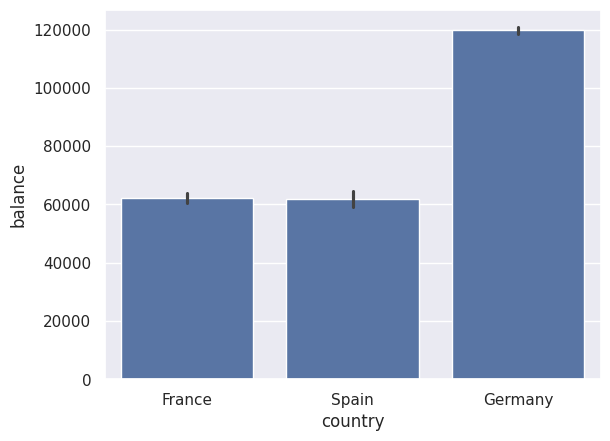

In [130]:
sns.barplot(x='country', y='balance', data=df);

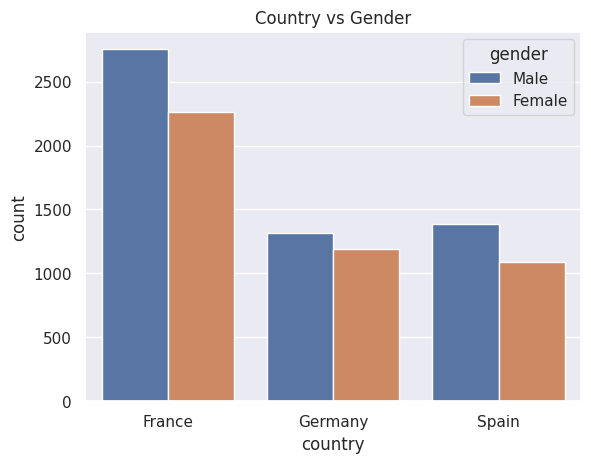

In [151]:
counts = df.groupby(['country'])['gender'].value_counts().rename('count').reset_index()
sns.barplot(x='country',y='count',hue='gender', data=counts).set_title('Country vs Gender');

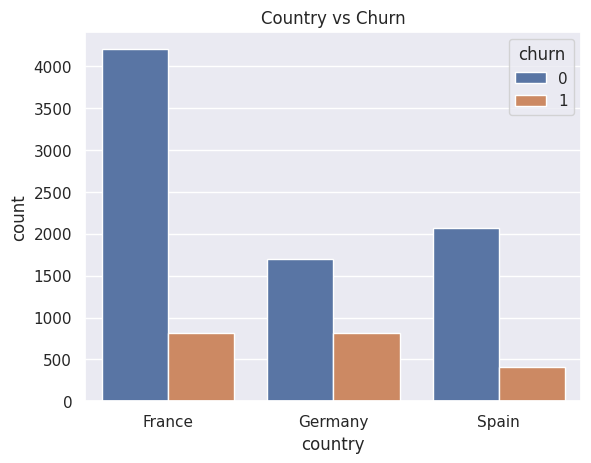

In [154]:
counts = df.groupby(['country'])['churn'].value_counts().rename('count').reset_index()
sns.barplot(x='country',y='count',hue='churn', data=counts).set_title('Country vs Churn');

In [141]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42.0,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41.0,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42.0,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39.0,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43.0,2,125510.82,1,1,1,79084.10,0


In [143]:
df_ages=df[['age','churn','country','gender','balance']]
df_ages['age_bin']=pd.cut(x=df_ages['age'], bins=[10,20,30,40,50,60,70])

<ipython-input-143-9a414a1d8063>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ages['age_bin']=pd.cut(x=df_ages['age'], bins=[10,20,30,40,50,60,70]);


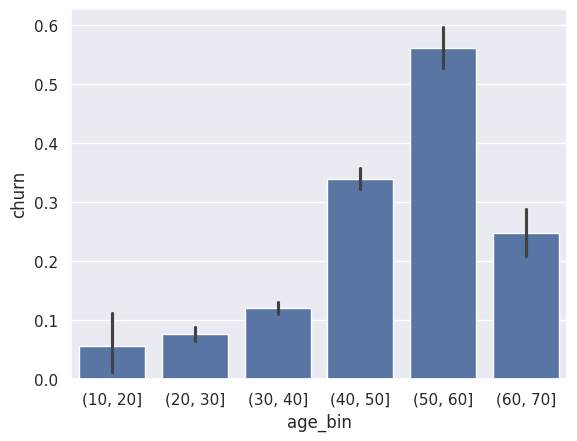

In [144]:
sns.barplot(x='age_bin',y='churn',data=df_ages);

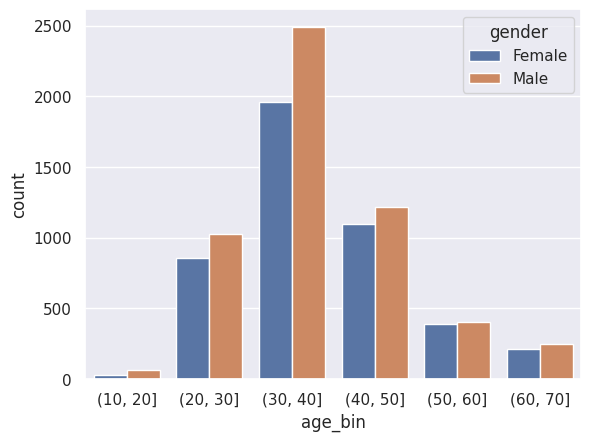

In [20]:
sns.countplot(data=df_ages, x='age_bin', hue='gender');

In [146]:
temp=df_ages['age_bin'].value_counts().reset_index().rename(columns={'index':'AgeBins','age_bin': 'count'})
temp

,AgeBins,count
0,"(30, 40]",4451
1,"(40, 50]",2320
2,"(20, 30]",1879
3,"(50, 60]",797
4,"(60, 70]",464
5,"(10, 20]",89


In [147]:
temp_1=df_ages.groupby(by='age_bin')['churn'].sum().reset_index().rename(columns={'age_bin':'AgeBins'})
temp_1

,AgeBins,churn
0,"(10, 20]",5
1,"(20, 30]",143
2,"(30, 40]",538
3,"(40, 50]",788
4,"(50, 60]",448
5,"(60, 70]",115


In [148]:
age_churn=temp.merge(temp_1, on ='AgeBins', how='left')
age_churn

,AgeBins,count,churn
0,"(30, 40]",4451,538
1,"(40, 50]",2320,788
2,"(20, 30]",1879,143
3,"(50, 60]",797,448
4,"(60, 70]",464,115
5,"(10, 20]",89,5


In [149]:
age_churn['churn_rate']=(age_churn['churn']/age_churn['count'])*100
age_churn

,AgeBins,count,churn,churn_rate
0,"(30, 40]",4451,538,12.087171
1,"(40, 50]",2320,788,33.965517
2,"(20, 30]",1879,143,7.610431
3,"(50, 60]",797,448,56.210790
4,"(60, 70]",464,115,24.784483
5,"(10, 20]",89,5,5.617978


[link text](https://)#### Insights from the EDA as follows:

1.   Female customers tend to churn more than the male customers
2.   Germany has the highest rate of churners. Also Germany has almost 50% female customers and hence it could be reason for high churn rate.
3.   Age is positively correlated with churn. 56.2 % churn rate among the customers aged between 50 to 60 is alarmingly high. Hence, the Bank should come up with a plan to keep their aging customers.

### Converting all objects to categorical codes

In [155]:
df = pd.get_dummies(df, columns=['gender','country'])

In [156]:
df.drop(['customer_id'],axis=1, inplace=True)

In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV

**Logistic Regression**

In [163]:
X = df.drop('churn', axis=1)
y = df['churn']

In [164]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size= 0.30, random_state=0)

In [165]:
# To check the dimensions on the train and test data
print('x_train: ',x_train.shape)
print('x_test: ',x_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)

x_train:  (7000, 13)
x_test:  (3000, 13)
y_train:  (7000,)
y_test:  (3000,)


In [167]:
model = LogisticRegression(solver='newton-cg',max_iter=100,penalty='none',verbose=True, random_state=2)
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


LogisticRegression(penalty='none', random_state=2, solver='newton-cg',
                   verbose=True)

### Prediction on train data

In [168]:
model.score(x_train, y_train)

0.8181428571428572

In [181]:
model.score(x_test, y_test)

0.816

In [173]:
ytrain_predict = model.predict(x_train)
ytest_predict = model.predict(x_test)

In [170]:
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

In [175]:
confusion_matrix(y_train, ytrain_predict)

array([[5387,  197],
       [1076,  340]])

In [180]:
confusion_matrix(y_test, ytest_predict)

array([[2294,   85],
       [ 467,  154]])

######  Insights
1076 data points are predicted as false negative.
In our Scenario recall is the most important factor since we do not miss out on churning customers. Hence we need to improve the model to increase the recall value

In [177]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      5584
           1       0.63      0.24      0.35      1416

    accuracy                           0.82      7000
   macro avg       0.73      0.60      0.62      7000
weighted avg       0.79      0.82      0.78      7000



In [176]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2379
           1       0.64      0.25      0.36       621

    accuracy                           0.82      3000
   macro avg       0.74      0.61      0.63      3000
weighted avg       0.79      0.82      0.78      3000



## SMOTE


*   SMOTE is usually used when we have imbalanced dataset to balance the data distribution



In [187]:
from imblearn.over_sampling import SMOTE

In [188]:
feature_df=df.drop('churn', axis=1)
label_df=df.churn

In [191]:
oversample = SMOTE()
transformed_feature_df, transformed_label_df = oversample.fit_resample(feature_df,label_df)

In [192]:
print(f'new label count :) {transformed_label_df.value_counts()}')

new label count :) 1    7963
0    7963
Name: churn, dtype: int64


In [193]:
X_train, X_test, y_train, y_test = train_test_split(transformed_feature_df,transformed_label_df, test_size= 0.30, random_state=0)

In [195]:
sm = LogisticRegression(solver='newton-cg',multi_class='ovr',verbose=True, random_state=2)
sm_model = sm.fit(X_train, np.ravel(y_train))

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [198]:
accuracy_1 = sm_model.score(X_train,y_train)
accuracy = sm_model.score(X_test,y_test)
print(f'sm_model accurcay of train data : {accuracy_1}')
print(f'sm_model accurcay of test data  : {accuracy}')

sm_model accurcay of train data : 0.8399712952996053
sm_model accurcay of test data  : 0.843658434491419


In [199]:
ytrain_predict = sm_model.predict(X_train)
ytest_predict = sm_model.predict(X_test)

In [200]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      5579
           1       0.88      0.79      0.83      5569

    accuracy                           0.84     11148
   macro avg       0.84      0.84      0.84     11148
weighted avg       0.84      0.84      0.84     11148



In [201]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85      2384
           1       0.87      0.80      0.84      2394

    accuracy                           0.84      4778
   macro avg       0.85      0.84      0.84      4778
weighted avg       0.85      0.84      0.84      4778



In [202]:
confusion_matrix(y_train, ytrain_predict)

array([[4959,  620],
       [1164, 4405]])

In [203]:
confusion_matrix(y_test, ytest_predict)

array([[2107,  277],
       [ 470, 1924]])

**Desicion** **tree** **Model**

In [204]:
X = df.drop('churn', axis=1)
y = df.churn

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.30, random_state=1)

In [206]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier


In [207]:
dt_model = DecisionTreeClassifier(criterion='gini')

In [208]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [209]:
y_train_pred = dt_model.predict(X_train)
ytest_pred = dt_model.predict(X_test)

In [210]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5590
           1       1.00      1.00      1.00      1410

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000



In [211]:
print(classification_report(y_test,ytest_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2373
           1       0.50      0.52      0.51       627

    accuracy                           0.79      3000
   macro avg       0.69      0.69      0.69      3000
weighted avg       0.79      0.79      0.79      3000



In [212]:
from sklearn import tree

In [213]:
train_label = ['0', '1']

In [214]:
tree_file = open('/content/drive/MyDrive/Colab Notebooks/Kaggle_1/kaggle_dt.dot', 'w')

In [215]:
d_data = tree.export_graphviz(dt_model, out_file =tree_file, feature_names= list(X_train), class_names=train_label)

In [216]:
tree_file.close()

In [217]:
mod_dt_model = DecisionTreeClassifier(criterion ='gini', max_depth=10, min_samples_leaf=10, min_samples_split=30)

In [218]:
mod_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=30)

In [219]:
reg_tree_file = open('/content/drive/MyDrive/Colab Notebooks/Kaggle_1/kaggle_dt_1.dot', 'w')
rg_d_data = tree.export_graphviz(mod_dt_model, out_file =reg_tree_file, feature_names= list(X_train), class_names=train_label)
reg_tree_file.close()

In [220]:
print(pd.DataFrame(mod_dt_model.feature_importances_, columns=['Imp'], index = X_train.columns))

                       Imp
credit_score      0.043035
age               0.341361
tenure            0.019109
balance           0.120699
products_number   0.236091
credit_card       0.004743
active_member     0.115060
estimated_salary  0.048762
gender_Female     0.009870
gender_Male       0.012589
country_France    0.001815
country_Germany   0.044522
country_Spain     0.002346


In [221]:
y_train_pred_1 = mod_dt_model.predict(X_train)
ytest_pred_1 = mod_dt_model.predict(X_test)

In [222]:
print(classification_report(y_train,y_train_pred_1))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      5590
           1       0.79      0.57      0.66      1410

    accuracy                           0.88      7000
   macro avg       0.84      0.77      0.80      7000
weighted avg       0.88      0.88      0.88      7000



In [223]:
print(classification_report(y_test,ytest_pred_1))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2373
           1       0.69      0.51      0.59       627

    accuracy                           0.85      3000
   macro avg       0.79      0.72      0.75      3000
weighted avg       0.84      0.85      0.84      3000

